<a href="https://colab.research.google.com/github/tzutingspace/web-crawling_gmaps_review/blob/main/Python_Selenium_on_colab_Google_Maps_%E7%BE%8E%E9%A3%9F%E8%A9%95%E8%AB%96%E5%88%86%E6%9E%90%E5%B0%88%E6%A1%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 雲端硬碟連線
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 更改路徑
import os
os.chdir('/content/drive/MyDrive/temp/google_maps_taichung2')
os.getcwd()

'/content/drive/MyDrive/temp/google_maps_taichung2'

# selenium on colab 方法
參考:
https://stackoverflow.com/questions/67948478/python-using-selenium-in-google-colab-to-automatically-input-data-into-google-d

參考: https://cyublog.com/articles/python-zh/colab-tutorial-selenium/

In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

In [ ]:
# import selenium 套件
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains

In [ ]:
# 測試
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
# 預設語言
chrome_options.add_argument("--lang=zh-TW.UTF-8")

driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.implicitly_wait(10)

driver.close() 

## GOOGLE MAP 抓取


#### import 套件

In [ ]:
import os
import time

import pandas as pd

import urllib
import requests
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

#### Define function ： 建立資料夾, make_dir(string)

In [ ]:
#建立資料夾
def make_dir(query):
  try:
      dis_name = query +'_data'
      os.mkdir(dis_name)
  except:
      pass

#### Define function ：店家資訊抓取 find_data(query, N=5)
2022/7/25 google maps 更新版, 店家頁面取消點擊下一頁方法, 改為向下滾動


In [ ]:
# google map 店家資訊抓取(with star and comment_count)

'''
inputs: query 預定查詢字串, N 為最低抓取店家數量
outpust: 無回傳值, 將查詢內容存於csv檔
'''

def find_data(query, N=5):
  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  translation_a = urllib.parse.quote(query)
  driver.get('https://www.google.com.tw/maps/search/' + translation_a + '/data=!3m1!4b1?hl=zh-TW')

  # 將欲收集資料建立空list
  href_link_list, title_list, star_list, comm_list  = [], [], [], []

  # 迴圈抓取清單, N等於最小店家數量
  #for _ in range(N):
  while len(title_list) < N:
    # scroll down
    element = driver.find_element(By.XPATH,'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]')
    for _ in range(15):
      time.sleep(1)
      element.send_keys(Keys.PAGE_DOWN)

    #分析網頁
    soup = BeautifulSoup(driver.page_source)
    
    #列表內所有資訊
    all_finding = soup.find_all('div', {'class': 'Nv2PK THOPZb CpccDe'})
    for temp_div in all_finding:
      #基本資料
      herf = temp_div.find('a', {'class': 'hfpxzc'})
      href_link = herf.get('href')
      title = herf.get('aria-label')
      href_link_list.append(href_link)
      title_list.append(title)

      # 評論與星級
      find_star = temp_div.find('span', {'class': 'ZkP5Je'})
      if find_star:
        star_list.append(find_star.text.split('(')[0].replace(',', '.'))
        try:
          comm_list.append(find_star.text.split('(')[1].replace(')', ''))
        except find_star.text.split('(')[1].replace(')', '') :
          comm_list.append(find_star.text.split('(')[1].replace(')', ''))
        except find_star.text.split('(')[0] :
          comm_list.append(find_star.text.split('(')[0])
      else:
        star_list.append("0")
        comm_list.append("0")

    #print(len(title_list),len(href_link_list), len(star_list),len(comm_list))
    print(f"已抓取 {len(title_list)} 筆{query}店家資料")
    time.sleep(2)
    
  driver.close() 

  #寫進資料庫
  df = pd.DataFrame()
  df['店名'] = title_list
  df['網址'] = href_link_list
  df['星級'] = star_list
  df['評論數量'] = comm_list
  df.to_csv(query + '_data/' + query + '_商家網址連結.csv', index=False, encoding='utf-8-sig')

#find_data('台中南區燒肉', N=1)

#### Define function : 篩選評論 filter_data(query, count=500, star=4.0, delete_list=[])

In [ ]:
# 對於查詢店家進行篩選

'''
inputs: query 預定查詢字串, count 評論數量, star 星級, delete_list 刪除特定字眼店名
outpust: 無回傳值, 將查詢內容存於csv檔
'''

def filter_data(query, count=500, star=4.0, delete_list=[]):
  df = pd.read_csv(query + '_data/' + query + '_商家網址連結.csv')
  df['評論數量'] = df['評論數量'].replace('沒有評論', '0')
  df['星級'] = df['星級'].replace('沒有評論', '0')
  df['評論數量'] = df['評論數量'].str.replace(',', '')
  df['星級'] = df[['星級']].astype(float)
  df['評論數量'] = df[['評論數量']].astype(int)
  df = df[(df["評論數量"] > count) & (df["星級"] > star)]
  df = df[-df['店名'].str.contains('|'.join(delete_list))]
  df['回復'] = ''
  df['地址'] = ''
  df['分類'] = ''
  df.to_csv(query + '_data/' + query + '_篩選評論.csv', encoding='utf-8-sig', index=False)
#filter_data('台中西區燒肉', delete_list = ['便當', '飯', '烤肉'])

In [ ]:
#pd.read_csv('台中南區燒肉' + '_data/' + '台中南區燒肉' + '_篩選評論.csv')

#### Define function ：抓取評論 get_comment_more(query, N=30)


In [ ]:
# 對於篩選後店家進行評論抓取

'''
inputs: query 預定查詢字串, N 預計抓取評論最低數量
outpust: 無回傳值, 將查詢內容存於csv檔
'''

def get_comment_more(query, N=30):
  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  df = pd.read_csv(query + '_data/' + query + '_篩選評論.csv')
  link = list(df['網址'])
  for i in range(len(link)):
    total_comment = df.loc[i, '評論數量']
    driver.get(link[i])
    time.sleep(3)
    driver.find_element(By.XPATH,'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]/div[1]').click()
    time.sleep(2)

    # 抓地址
    soup2 = BeautifulSoup(driver.page_source)
    address = soup2.find('div', {'class': 'Io6YTe fontBodyMedium'}).text
    time.sleep(3)

    # 抓分類
    category = soup2.find_all('button',{'class' : 'DkEaL'})[1].text

    # 點選所有評論
    driver.find_element(By.CLASS_NAME,'DkEaL').click()
    time.sleep(3)

    #點選最新評論
    try:
      driver.find_elements(By.CLASS_NAME, 'S9kvJb')[4].click()
      time.sleep(3)
      driver.find_elements(By.CLASS_NAME, 'fxNQSd')[1].click()
      time.sleep(3)
    except: pass

    # 抓評論 N 筆
    comm_list = []
    count_now = 999999
    while len(comm_list) <= N and len(comm_list) < int(total_comment) and count_now != len(comm_list):
      print(f'抓取 {df.loc[i, "店名"]} 評論中, 目前已抓取{len(comm_list)}筆......', end='')
      count_now = len(comm_list)
      element = driver.find_element(By.XPATH,'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]')
      for j in range(30):
        time.sleep(0.5)
        element.send_keys(Keys.PAGE_DOWN)
      time.sleep(3)

      try:
          buttons = driver.find_elements(By.XPATH, "//button[text()='全文']")
          time.sleep(3)
          for button in buttons:
              button.click()
              time.sleep(1)
              print('click', end='')
          print()
      except: pass

      soup1 = BeautifulSoup(driver.page_source)
      comm = soup1.find_all('span', {'class': 'wiI7pd'})
      for ww in comm:
        coment= ww.text.replace(' 位評論者', '').replace('"', '').replace('   ', '').replace('  ', '')
        if coment not in comm_list:
          comm_list.append(coment)
        else: continue
      time.sleep(2)
    print(f">>> {df.loc[i, '店名']}共抓取 {len(comm_list)} 筆留言資料")
    df.loc[i, '回復'] = str(comm_list)
    df.loc[i, '地址'] = str(address)
    df.loc[i, '分類'] = str(category)
    time.sleep(2)

  df.to_csv(query + '_data/' + query + '_抓取留言.csv', encoding='utf-8-sig', index=False)
  driver.close()
#get_comment_more('台中南區燒肉')

#### All 執行所有Function


In [ ]:
city = '台中'
district_list = ['']
food_type_list = ['美食']

In [ ]:
for district in district_list:
  for food_type in food_type_list:
    query = city + district + food_type
    print(f'關鍵字:{query}')
    make_dir(query)
    find_data(query, N=20) #店家搜尋
    filter_data(query, count=500, star=3.0, delete_list=['便當', '飯', '烤肉飯']) #篩選店家 評論數>500, star > 3, 扣除便當店等
    print('準備抓取 店家 評論')
    get_comment_more(query, N=100) #抓取最新評論100則, &地址,餐廳分類
    #get_image(query)

關鍵字:台中美食
已抓取 25 筆台中美食店家資料
準備抓取 店家 評論
抓取 Offer Oh昨日花卷 跨界好食 評論中, 目前已抓取0筆......clickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclick
抓取 Offer Oh昨日花卷 跨界好食 評論中, 目前已抓取41筆......clickclickclickclickclickclickclickclickclick
抓取 Offer Oh昨日花卷 跨界好食 評論中, 目前已抓取69筆......clickclickclickclickclickclickclickclickclick
抓取 Offer Oh昨日花卷 跨界好食 評論中, 目前已抓取93筆......clickclickclickclickclickclickclickclickclickclick
>>> Offer Oh昨日花卷 跨界好食共抓取 114 筆留言資料
抓取 JAI 宅 評論中, 目前已抓取0筆......clickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclickclick
抓取 JAI 宅 評論中, 目前已抓取24筆......clickclickclickclickclickclickclickclickclickclickclickclickclick
抓取 JAI 宅 評論中, 目前已抓取45筆......clickclickclickclickclickclickclickclickclickclickclickclickclickclickclick
抓取 JAI 宅 評論中, 目前已抓取68筆......clickclickclickclickclickclickclickclickclickclickclickclickclickclick
抓取 JAI 宅 評論中, 目前已抓取86筆......clickclickclickclickclickclickclickcl

#### 初步結果確認

In [ ]:
df_all = pd.DataFrame()
for district in district_list:
  query = city + district + food_type_list[0]
  df = pd.read_csv(query + '_data/' + query + '_抓取留言.csv')
  df_all = pd.concat([df_all,df], axis=0)

In [ ]:
taichung_district_list = ['中區', '東區', '西區', '南區', '北區', '西屯區', '南屯區', '北屯區', '豐原區', '大里區', 
                         '太平區', '清水區', '沙鹿區', '大甲區', '東勢區', '梧棲區', '烏日區', '神岡區', '大肚區', 
                         '大雅區', '后里區', '霧峰區', '潭子區', '龍井區', '外埔區', '和平區', '石岡區', '大安區', '新社區']

In [ ]:
# 新增行政區
# ref: https://stackoverflow.com/questions/70449278/can-pandas-findall-return-a-str-instead-of-list
df_all['行政區']= df_all['地址'].str.findall('|'.join(taichung_district_list)).str.join(", ")

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   店名      18 non-null     object 
 1   網址      18 non-null     object 
 2   星級      18 non-null     float64
 3   評論數量    18 non-null     int64  
 4   回復      18 non-null     object 
 5   地址      18 non-null     object 
 6   分類      18 non-null     object 
 7   行政區     18 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.2+ KB


In [ ]:
df_all.head(3)

,店名,網址,星級,評論數量,回復,地址,分類,行政區
0,Offer Oh昨日花卷 跨界好食,https://www.google.com.tw/maps/place/Offer+Oh%...,4.4,3216,"['', '第一次到訪，菜色選擇很多，這次點了雙人套餐~\n烤日式檸香雞：肉質軟嫩、醬汁夠味...",403台灣台中市西區忠誠街91號,多國菜餐廳,西區
1,JAI 宅,https://www.google.com.tw/maps/place/JAI+%E5%A...,4.5,4571,['星期六中午12:30來用餐，有提早一週先訂位，當時店內已經坐滿三分之二，假日提早訂位應該...,404台灣台中市北區三民路三段125號2樓,餐廳,北區
2,Mr.38 咖哩美食餐廳（一中店）,https://www.google.com.tw/maps/place/Mr.38+%E5...,4.5,4781,"['', '服務好 餐點好吃', '咖喱蠻好吃的但是價格小貴。服務生也蠻熱心的。', '套餐...",404台灣台中市北區一中街109號,餐廳,北區


In [ ]:
df_all['地址'].duplicated().sum()

0

In [ ]:
df_all[df_all['地址'].duplicated()].head(1)

,店名,網址,星級,評論數量,回復,地址,分類,行政區


In [ ]:
df_all[df_all['地址'] == '404台灣台中市北區育才街3號1樓']

,店名,網址,星級,評論數量,回復,地址,分類,行政區


In [ ]:
df_all.drop_duplicates(subset=['地址'], inplace = True)
df_all.reset_index(drop=True, inplace = True)
df_all.tail(3)

,店名,網址,星級,評論數量,回復,地址,分類,行政區
15,御饌臻品-安和店 / 台中美食 / 家庭聚餐 / Chinese restaurant / ...,https://www.google.com.tw/maps/place/%E5%BE%A1...,4.3,1955,['👎🏾超壞的用餐經驗 店家結帳金額多收還怪客人沒有結帳👎🏾\n\n結帳的時候覺得金額不合理...,407台灣台中市西屯區安和路127-27號,中餐館,西屯區
16,台中肉員,https://www.google.com.tw/maps/place/%E5%8F%B0...,4.1,7043,"['藥劑味超重', '外帶結帳快速', '不管何時去，客人都是源源不絕的。座無虛席。每次帶外...",402台灣台中市南區復興路三段529號,熟食店,南區
17,Mr.38 咖哩美食餐廳（逢甲店）,https://www.google.com.tw/maps/place/Mr.38+%E5...,4.6,4777,"['服務好，餐點美味！', '(由 Google 提供翻譯) 好吃 份量也多👍👍👍👍\n\n...",407台灣台中市西屯區至善路212號,日式咖哩餐廳,西屯區


In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   店名      18 non-null     object 
 1   網址      18 non-null     object 
 2   星級      18 non-null     float64
 3   評論數量    18 non-null     int64  
 4   回復      18 non-null     object 
 5   地址      18 non-null     object 
 6   分類      18 non-null     object 
 7   行政區     18 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.2+ KB


In [ ]:
df_all['地址'].duplicated().sum()

0

In [ ]:
df_byDistrict = df_all.groupby('行政區').agg({'店名': ['count'], '星級': ['mean', 'min', 'max'], '評論數量': ['mean', 'min', 'max']})
df_byDistrict

店名     星級              評論數量            
    count   mean  min  max    mean   min   max
行政區                                           
中區      1  4.400  4.4  4.4  1715.0  1715  1715
北區      4  4.425  4.3  4.5  2804.5   815  4781
南區      1  4.100  4.1  4.1  7043.0  7043  7043
南屯區     4  4.300  4.1  4.6  1882.5  1224  3238
東區      1  4.400  4.4  4.4  2464.0  2464  2464
西區      4  4.250  4.0  4.5  4751.0  3216  8554
西屯區     3  4.400  4.3  4.6  2863.0  1857  4777

In [ ]:
df_byCat = df_all.groupby('分類').agg({'店名': ['count'], '星級': ['mean', 'min', 'max']})
df_byCat

店名     星級          
           count   mean  min  max
分類                               
中式包點店          1  4.400  4.4  4.4
中餐館            2  4.150  4.0  4.3
台灣餐廳           1  4.200  4.2  4.2
壽喜燒和日式火鍋餐廳     1  4.600  4.6  4.6
多國菜餐廳          1  4.400  4.4  4.4
意大利餐廳          1  4.300  4.3  4.3
日式咖哩餐廳         1  4.600  4.6  4.6
日式燒肉餐廳         2  4.400  4.3  4.5
早午餐餐廳          1  4.300  4.3  4.3
熟食店            1  4.100  4.1  4.1
粥餐廳            1  4.100  4.1  4.1
酒樓             1  4.400  4.4  4.4
餐廳             4  4.375  4.1  4.5

In [ ]:
df_all['回復'][0]

"['', '第一次到訪，菜色選擇很多，這次點了雙人套餐~\\n烤日式檸香雞：肉質軟嫩、醬汁夠味👍\\n凱撒揚雞沙拉：份量充足！雞肉鮮嫩多汁，搭配凱薩醬再灑上起司條，一口接一口停不下來👏\\n叫化子雞火烤飯：很有特色，帶一點胡椒味，是口味比較重的料理，嚐鮮推👍', '餐點特別，叫化子雞火烤飯口味重、份量足，菊花枸杞紅茶好喝解膩，令人驚豔。', '花卷好吃，生日前後一週送杯子，不過最近人手有點不足的感覺', '東西好吃，非常有特色，值得再訪。', '九層搭唐揚雞搭配台式麵條、日式雞肉、義式青醬，呈現另一種滋味，美味不設限，份量十足，cp值破表。', '7/17午餐用餐，建議店家可以現場給個服務滿意度調查表，由於同行同伴比較晚到，需要點餐，但幾乎所有時間都花在等點餐人員來到，因為等了20分鐘最後還是必須直接到櫃台點餐，一頓飯吃了3個小時，雖然沒有所有人在預定時間抵達是我們的問題，但是為了點餐要等這麼久很難以理解，而且同伴點完提出餐點直接外帶需求，結果也被拒絕，規矩這麼硬令人困擾', '食材新鮮，料理美味，物超所值', '專門來吃商業午餐，點了秘滷凍牛肉花卷、紅咖哩牛火烤飯，都好好吃唷😚甜點奶酪也很推薦～', '不管是什麼都等很久、服務員一人當3人用、外場只有2人，6：30用餐到8點多…中間都是等餐等服務員，能理解人員不足,最後願餐完等很久不見收拾送甜點，需要主動走去吧檯詢問…但綁馬尾女生態度有夠差…以後應該不會在來這餐廳，希望可以加油！', '還會想再來訪的餐廳', '內裝不錯看，五顆星送飲料活動', '餐點特別、用餐環境氣氛佳！', '好吃，適合上班族。', '光等餐點就等到飽了\\n\\n不管口味如何我都不會再來第二次了\\n光等主餐可以等40分鐘以上根本浪費時間\\n\\n—————更\\n外場反應因只有一位廚師所以出餐會比較慢\\n但要是這樣應該是一開始點餐時就說吧？\\n不然就是你們自己要補人吧？\\n都點完最後將近一小時還是沒有出餐\\n我直接把我所有餐點的費用結清共800多\\n不要說我凹你們\\n我吃不起你們這種高貴店家的餐\\n你賺的到這一次我的錢\\n但我絕對不會去第二次\\n\\n要來吃飯的人也請三思 光等餐就要等那麼久\\n連開胃菜都可以25分鐘後才上了\\n除非你時間很多可以為了個餐等上一小時\\n\\n中午離開公司吃個午餐要受你們這種氣\\n

### 文字探勘


In [ ]:
! pip install emoji
! pip install emojiswitch
! pip3 install -U emojis
! pip install opencc-python-reimplemented

# https://pypi.org/project/ckip-transformers/
! pip install -U transformers
! pip install -U ckip-transformers

In [ ]:
!wget -O dict.txt.big.txt https://raw.githubusercontent.com/fxsjy/jieba/master/extra_dict/dict.txt.big

--2022-07-09 08:23:33--  https://raw.githubusercontent.com/fxsjy/jieba/master/extra_dict/dict.txt.big
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8583143 (8.2M) [text/plain]
Saving to: ‘dict.txt.big.txt’

dict.txt.big.txt    100%[===================>]   8.18M  46.6MB/s    in 0.2s    

2022-07-09 08:23:34 (46.6 MB/s) - ‘dict.txt.big.txt’ saved [8583143/8583143]



In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba
from collections import Counter
from PIL import Image
import numpy as np
import requests

In [ ]:
#import os
os.chdir('/content/drive/MyDrive/temp')

#with open('stopWord_cloud.txt', 'r', encoding='utf-8-sig') as f:
with open('stopWord_cloudmod.txt', 'r', encoding='utf-8-sig') as f:
    stops = f.read().split('\n')
jieba.set_dictionary('dict.txt.big.txt')  

In [ ]:
query = '台中北區燒肉'
df = pd.read_csv( query + '_data/' + query + '_抓取留言.csv')

In [ ]:
df['回復'][0]

"['', '服務人員親切，餐點的品質很好，還有味噌湯可以喝，這次餐點有生豪，生豪的新鮮度不錯，生吃是一大享受，大推～～～～😁', '(由 Google 提供翻譯) 好吃好吃一直推\\n\\n(原始評論)\\n好吃好吃一直推', 'Duncan 推薦的胸腺超讚！可以兩個人以上分著吃比較不會太膩～', '週五下班就是要吃燒肉，店員服務很親切，明太子薯片燒大推👍👍👍👍', '(由 Google 提供翻譯) 很好吃！\\n\\n(原始評論)\\n很好吃！', '氣氛很棒很棒！', '看下面很多好評來的，但實際上沒有桌邊幫忙烤服務，如果以台中燒肉這價位會有更多店家可以選擇，上次來台中吃的其他店家有桌邊服務飽到吃不下之外價格還更便宜些，名不副實，今天吃完後的感想😅', '氣氛好～服務好，餐點很好吃👍', '(由 Google 提供翻譯) 嗚嗚嗚！\\n\\n(原始評論)\\ngoooooooood！', '(由 Google 提供翻譯) 送炸麻糬\\n\\n(原始評論)\\n送炸麻糬', '讚', '(由 Google 提供翻譯) 好好吃\\n\\n(原始評論)\\n好好吃', '桌邊服務超級好，專業幫忙燒烤果然厲害👍', '食材新鮮 好吃\\n服務人員解說介紹很詳細\\n幫忙拷的服務\\n讓食材能更好的品嚐出原味', '餐點豐富美味，值得再訪', '肉很好吃服務很好👍🏽', '聚餐好地方\\n還會幫忙烤肉太棒了👏🏻', '聚餐的厚所在👍服務超好', '第一次來，氣氛熱鬧，很適合一群朋友聚餐', '店內氣氛佳', '店家氣氛好，店員服務熱心，食物也好吃，推推', '水準可以', '店員服務很棒, 日式炒麵齁甲', '店員Duncan服務熱情有禮貌，很會推薦燒肉品項菜色，食材多元新鮮好吃，每個月特定時間還有許多有趣的小活動，是值得回訪的好餐廳', '好吃，服務親切，飽足的一餐', '肉質超級好吃！', '很好吃～服務周到\\n店員烤得一級棒', '店員林淵超讚👍🏻👍🏻', '好吃服務又好，因為剛好客人較少的時段，還特地幫我們烤肉及解說！超棒！', '瘋狗帥，東西好吃，服務很棒，可以常來', '吃過屋馬 訂不到茶六\\n找了google評價4.9的燒肉 試一下\\n2個人吃3400\\n\\n覺得 物無所值\\n\\n打卡5星好評 送烤麻糬\\n(看到牌子發現評價是這樣來的)\\

In [ ]:
reviews = list(df['回復'])
review_analytics = []
for review in reviews:
  review = review.replace('[', '').replace(']', '').replace('(由 Google 提供翻譯)','').replace('(原始評論)','').replace('\\n',',')
  for i, j in enumerate(review.split("'")):
    if j not in ['', ', ']:
      #print(j)
      review_analytics.append(j)

In [ ]:
review_analytics[:10]

['服務人員親切，餐點的品質很好，還有味噌湯可以喝，這次餐點有生豪，生豪的新鮮度不錯，生吃是一大享受，大推～～～～😁',
 ' 好吃好吃一直推,,,好吃好吃一直推',
 'Duncan 推薦的胸腺超讚！可以兩個人以上分著吃比較不會太膩～',
 '週五下班就是要吃燒肉，店員服務很親切，明太子薯片燒大推👍👍👍👍',
 ' 很好吃！,,,很好吃！',
 '氣氛很棒很棒！',
 '看下面很多好評來的，但實際上沒有桌邊幫忙烤服務，如果以台中燒肉這價位會有更多店家可以選擇，上次來台中吃的其他店家有桌邊服務飽到吃不下之外價格還更便宜些，名不副實，今天吃完後的感想😅',
 '氣氛好～服務好，餐點很好吃👍',
 ' 嗚嗚嗚！,,,goooooooood！',
 ' 送炸麻糬,,,送炸麻糬']

In [ ]:
#stops.append(' ')
stops.append('')

In [ ]:
terms = []
for text in review_analytics:
  for t in jieba.cut(text, cut_all=False):
      if t not in stops:
          terms.append(t)
  diction = Counter(terms)

In [ ]:
diction.most_common(50)

[('好吃', 612),
 ('服務', 440),
 ('好', 370),
 ('吃', 355),
 ('👍', 217),
 ('不錯', 163),
 ('人員', 145),
 ('讚', 140),
 ('真的', 132),
 ('餐點', 131),
 ('用餐', 121),
 ('肉', 113),
 ('烤', 107),
 ('環境', 98),
 ('親切', 97),
 ('新鮮', 95),
 ('️', 90),
 ('很棒', 89),
 ('牛', 84),
 ('態度', 84),
 ('超', 82),
 ('東西', 82),
 ('人', 81),
 ('店員', 78),
 ('😋', 76),
 ('服務態度', 76),
 ('食材', 73),
 ('推薦', 71),
 ('美味', 68),
 ('套餐', 68),
 ('說', 68),
 ('燒肉', 67),
 ('❤', 66),
 ('好喝', 64),
 ('覺得', 63),
 ('客人', 61),
 ('牛肉', 60),
 ('品質', 57),
 ('丼', 57),
 ('串燒', 57),
 ('感覺', 56),
 ('份量', 55),
 ('飯', 54),
 ('店家', 53),
 ('店', 53),
 ('朋友', 52),
 ('味道', 52),
 ('😍', 52),
 ('推', 51),
 ('值得', 51)]

In [ ]:
terms_drop = [i for i in terms if i not in['烤肉', '燒肉', '好吃','烤', '吃', '不錯', '便當', '推薦', '好', '覺得','」',' ','']] 

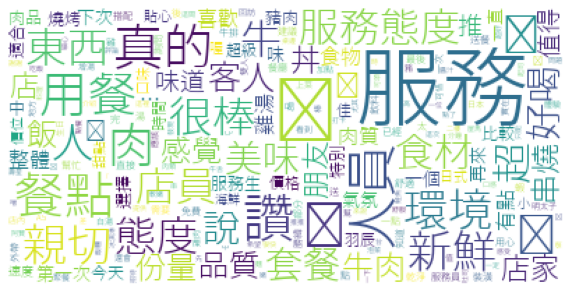

In [ ]:
diction = Counter(terms_drop)
fontfile = requests.get("https://drive.google.com/uc?id=1QdaqR8Setf4HEulrIW79UEV_Lg_fuoWz&export=download")
with open('taipei_sans_tc_beta.ttf', 'wb') as f:
  f.write(fontfile.content)
#wordcloud = WordCloud(font_path='taipei_sans_tc_beta.ttf') 
#mask = np.array(Image.open("heart2.jpeg")) 
wordcloud = WordCloud(background_color="white", font_path='taipei_sans_tc_beta.ttf')#, mask=mask) 
wordcloud.generate_from_frequencies(frequencies=diction)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#wordcloud.to_file("heart.png")

### emoji 判斷
https://pypi.org/project/emoji/  
https://pypi.org/project/emojis/

In [ ]:
import emoji
import emojiswitch
import re
from opencc import OpenCC
terms2 = []
for word in terms_drop:
  #if u"\uE000" <= word and word <= u"\uE900" or u"\U0001F000" <= word and word <= u"\U0001FA99":
  if emoji.is_emoji(word):
    print(word, end='') 
    #print(emoji.demojize(word))
    print(OpenCC('s2twp').convert(emojiswitch.demojize(word, lang = 'zh')), end='')
    emoji_= OpenCC('s2twp').convert(emojiswitch.demojize(word, lang = 'zh'))
    emoji_ = emoji_.replace(":", '')
    print(emoji_)
    terms2.append(emoji_)
  else:
    terms2.append(word)

😁:笑眯眯的臉:笑眯眯的臉
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
😅:滿臉汗水:滿臉汗水
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
🏽:中等膚色:中等膚色
👏:拍手:拍手
🏻:淺膚色:淺膚色
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
🏻:淺膚色:淺膚色
👍:豎起大拇指:豎起大拇指
🏻:淺膚色:淺膚色
🤣:在地板上打滾大笑:在地板上打滾大笑
😋:品嚐食物的臉:品嚐食物的臉
👍:豎起大拇指:豎起大拇指
😋:品嚐食物的臉:品嚐食物的臉
🥳:派對臉:派對臉
🤙:叫我手:叫我手
👍:豎起大拇指:豎起大拇指
🥰:三顆心的笑臉:三顆心的笑臉
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
😋:品嚐食物的臉:品嚐食物的臉
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
😋:品嚐食物的臉:品嚐食物的臉
😅:滿臉汗水:滿臉汗水
👍:豎起大拇指:豎起大拇指
😋:品嚐食物的臉:品嚐食物的臉
😋:品嚐食物的臉:品嚐食物的臉
👍:豎起大拇指:豎起大拇指
🏼:中淺膚色:中淺膚色
❤:紅心:紅心
👍:豎起大拇指:豎起大拇指
😋:品嚐食物的臉:品嚐食物的臉
😋:品嚐食物的臉:品嚐食物的臉
😋:品嚐食物的臉:品嚐食物的臉
❤:紅心:紅心
☺:笑臉:笑臉
😋:品嚐食物的臉:品嚐食物的臉
😋:品嚐食物的臉:品嚐食物的臉
😋:品嚐食物的臉:品嚐食物的臉
👍:豎起大拇指:豎起大拇指
🏻:淺膚色:淺膚色
👍:豎起大拇指:豎起大拇指
🏻:淺膚色:淺膚色
👍:豎起大拇指:豎起大拇指
🏻:淺膚色:淺膚色
👍:豎起大拇指:豎起大拇指
🏻:淺膚色:淺膚色
👍:豎起大拇指:豎起大拇指
🏻:淺膚色:淺膚色
👍:豎起大拇指:豎起大拇指
🏻:淺膚色:淺膚色
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
🤤:流口水的臉:流口水的臉
🤤:流口水的臉:流口水的臉
👍:豎起大拇指:豎起大拇指
👍:豎起大拇指:豎起大拇指
😄:笑眯眯的臉:笑眯眯的臉
👍:豎起大拇指:豎起大拇指
😍:心眼笑臉:心眼笑臉
😍:心眼笑臉:心眼笑臉
😍:心眼笑臉:心眼笑臉
😅:滿臉汗水:滿臉汗水
🤣:在地板上打滾大笑:在地板上打

In [ ]:
terms_drop2 = [i for i in terms if i not in['烤肉', '燒肉', '好吃','烤', '吃', '不錯', '便當', '推薦']] 

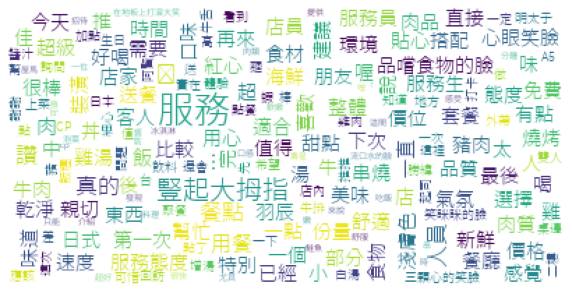

In [ ]:
diction = Counter(terms2)
fontfile = requests.get("https://drive.google.com/uc?id=1QdaqR8Setf4HEulrIW79UEV_Lg_fuoWz&export=download")
with open('taipei_sans_tc_beta.ttf', 'wb') as f:
  f.write(fontfile.content)
#wordcloud = WordCloud(font_path='taipei_sans_tc_beta.ttf') 
#mask = np.array(Image.open("heart2.jpeg")) 
wordcloud = WordCloud(background_color="white", font_path='taipei_sans_tc_beta.ttf')#, mask=mask) 
wordcloud.generate_from_frequencies(frequencies=diction)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#wordcloud.to_file("heart.png")

## 各城市文字分析

### 比較各縣市燒肉店狀況？？

In [ ]:
import os 
import requests
import pandas as pd

In [ ]:
os.chdir('/content/drive/MyDrive/temp/google_maps_city')

df_all = pd.DataFrame()
for floder in filter(lambda x : x.endswith('_data'), os.listdir()):
  #print(floder)
  for csv in filter(lambda x : x.endswith('抓取留言.csv'), os.listdir(floder)):
    #print(csv)
    df = pd.read_csv(floder + '/' + csv)
    df_all = pd.concat([df_all, df], axis=0)

In [ ]:
print(f"重複資料: {df_all['地址'].duplicated().sum()}")
df_all.info()

重複資料: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 13
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   店名      140 non-null    object 
 1   網址      140 non-null    object 
 2   星級      140 non-null    float64
 3   評論數量    140 non-null    int64  
 4   回復      140 non-null    object 
 5   地址      140 non-null    object 
 6   分類      140 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 8.8+ KB


In [ ]:
df_byCat = df_all.groupby('分類').agg({'店名': ['count'], '星級': ['mean', 'min', 'max'], '評論數量': ['mean', 'min', 'max']})
df_byCat

店名        星級                   評論數量             
       count      mean  min  max         mean   min    max
分類                                                        
壽喜燒餐廳      1  4.200000  4.2  4.2   935.000000   935    935
日式燒肉餐廳    98  4.490816  3.9  4.9  2861.928571   550  13277
日本餐廳       1  4.800000  4.8  4.8  3274.000000  3274   3274
燒烤         1  4.600000  4.6  4.6  2607.000000  2607   2607
燒烤餐廳      16  4.393750  4.0  4.7  2297.125000   607   6119
酒吧扒房      10  4.470000  3.8  4.9  2122.800000   867   4414
餐廳        13  4.584615  3.8  4.9  2466.230769   568   9137

In [ ]:
city = ['臺北市', '台北市', '新北市', '桃園市', '臺中市', '台中市', '臺南市', '台南市',
        '高雄市', '新竹縣', '苗栗縣', '彰化縣', '南投縣', '雲林縣', '嘉義縣', '屏東縣',
        '宜蘭縣', '花蓮縣', '臺東縣', '台東縣', '澎湖縣', '金門縣', '連江縣', '基隆市', '新竹市', '嘉義市']
df_all['城市']= df_all['地址'].str.findall('|'.join(city)).str.join(", ")

In [ ]:
df_byCity = df_all.groupby('城市').agg({'店名': ['count'], '星級': ['mean', 'min', 'max'], '評論數量': ['mean', 'min', 'max']})
df_byCity

店名        星級                   評論數量            
    count      mean  min  max         mean  min    max
城市                                                    
台中市    19  4.510526  4.0  4.9  3731.473684  588  10911
台北市    17  4.564706  4.1  4.9  1968.764706  577   5607
台南市    18  4.472222  3.9  4.8  3647.666667  550  13277
嘉義市    14  4.492857  3.9  4.8  2034.285714  714   5781
基隆市     9  4.466667  4.2  4.9  2529.333333  645   9137
新北市    15  4.513333  4.3  4.8  2757.600000  637   6119
新竹市    12  4.366667  3.8  4.9  2021.833333  580   4657
桃園市    18  4.544444  4.2  4.9  2032.500000  607   4203
高雄市    18  4.416667  4.0  4.9  2991.555556  582  10495

In [ ]:
df_review = pd.DataFrame()
df_review['城市'] = list(df_byCity.index)
df_review['評論'] = ''
df_review = df_review.set_index('城市')
df_review

In [ ]:
for city in list(df_byCity.index):
  review_temp = ''
  review_analytics = []
  for review in df_all.loc[df_all['城市'] == city, '回復']:
    review_temp += review
  #print(city, review_temp)
  #df_byCity.loc[city, '回復'] = review_temp
  review_temp = review_temp.replace('[', '').replace(']', '').replace('(由 Google 提供翻譯)','').replace('(原始評論)','').replace('\\n',',')
  for i, j in enumerate(review_temp.split("'")):
    if j not in ['', ', ', ' ']:
      review_analytics.append(j)
  #print(city)
  df_review.loc[city, '評論'] = review_analytics
df_review

,評論
城市,
台中市,[今天與家人來紅巢聚餐，非常開心，我要讚美❤️莉琳❤️，她為我們的代烤，讓每道肉盤更加美味了...
台北市,"[ 不太好吃,,,不太好吃, 燒肉吃到飽,推薦你很餓再來，不然吃沒幾下就飽了,服務生很親切幫..."
台南市,"[ Dis餐廳是🔥🔥🔥🔥🔥,,,Dis restaurant is 🔥🔥🔥🔥🔥, 普普，但裡..."
嘉義市,"[大寶服務太讚了, 大寶 小瑩 很棒, 大寶 小瑩 讚, 大寶 小瑩 服務很好, 大寶 小瑩..."
基隆市,"[人員服務很好 時不時會關心用餐狀況,撥蝦時會主動遞上濕紙巾 會再找朋友來聚餐, 服務員工：..."
新北市,"[肉蠻新鮮的，688，888價值得。,乾淨還有服務態度很親切。, 服務好讚👍🏻, 超級好吃，..."
新竹市,"[好吃 謝謝YJ sir, 肉好吃，服務也很好！值得推薦, 好吃，有人出錢就是棒🧐, 適合細..."
桃園市,"[👍大推自助吧的藥燉排骨，圓片什麼排的也很好吃推薦指數5顆星, 第一次吃，一開始有點失望，肉..."
高雄市,[老婆生日餐、第一次造訪就被店長服務，食材原味不過分調味壓蓋掩飾、內涵很足夠還跟店長學習不少...


In [ ]:
fontfile = requests.get("https://drive.google.com/uc?id=1QdaqR8Setf4HEulrIW79UEV_Lg_fuoWz&export=download")
with open('taipei_sans_tc_beta.ttf', 'wb') as f:
  f.write(fontfile.content)

In [ ]:
import emojis

In [ ]:
# 確認是否為中文
def is_contains_chinese(strs):
    for _char in strs:
        if '\u4e00' <= _char <= '\u9fa5':
            return True
    return False

In [ ]:
adv_list = ['真的', '不錯', '覺得', '好像', '  ']
for word in adv_list:
  stops.append(word)

In [ ]:
review_analytics = df_review.loc['台中市', '評論']
for text in review_analytics:
  for t in jieba.cut(text, cut_all=False):
    if t not in stops and emojis.get(t) == set() and is_contains_chinese(t):
      print(t)
      print(emojis.get(t))

台中市
[('服務', 462), ('好吃', 332), ('人員', 142), ('肉', 110), ('牛', 97), ('親切', 79), ('烤', 78), ('用餐', 77), ('肉品', 77), ('套餐', 74)]


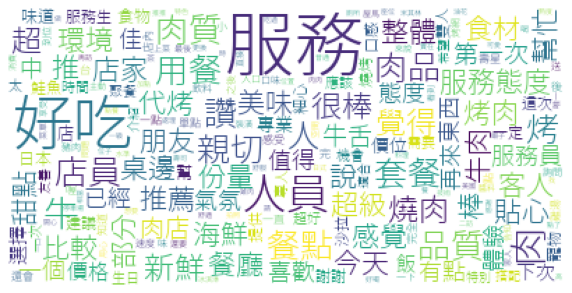

台北市
[('服務', 424), ('好吃', 333), ('烤', 126), ('牛', 112), ('肉', 108), ('用餐', 99), ('燒肉', 98), ('人員', 97), ('讚', 94), ('店員', 90)]


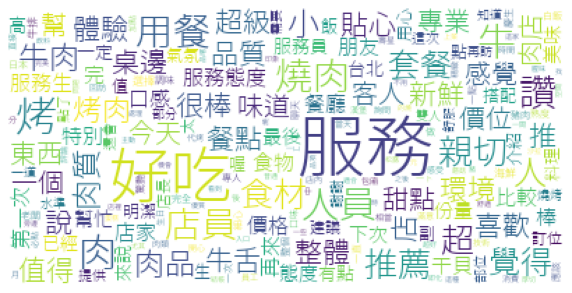

台南市
[('好吃', 352), ('服務', 346), ('烤', 147), ('肉', 121), ('人員', 109), ('店員', 109), ('用餐', 92), ('說', 90), ('燒肉', 79), ('新鮮', 78)]


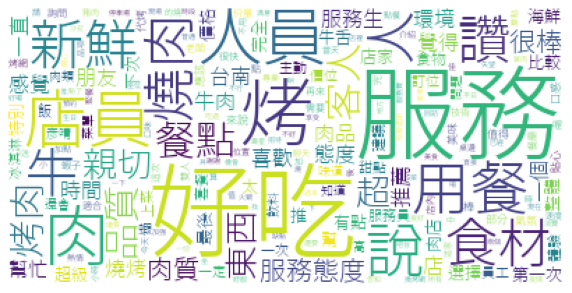

嘉義市
[('服務', 250), ('好吃', 241), ('親切', 66), ('人員', 64), ('食材', 62), ('肉', 60), ('烤', 60), ('讚', 58), ('新鮮', 54), ('服務態度', 50)]


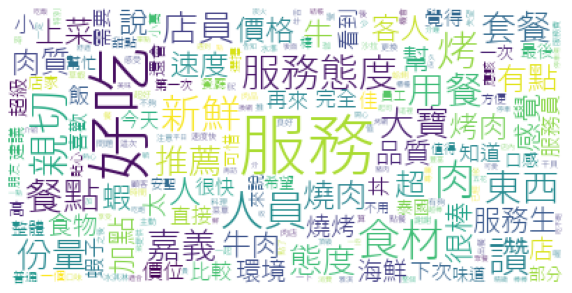

基隆市
[('服務', 204), ('好吃', 156), ('肉', 67), ('用餐', 62), ('人員', 57), ('店員', 54), ('讚', 51), ('新鮮', 47), ('食材', 44), ('親切', 41)]


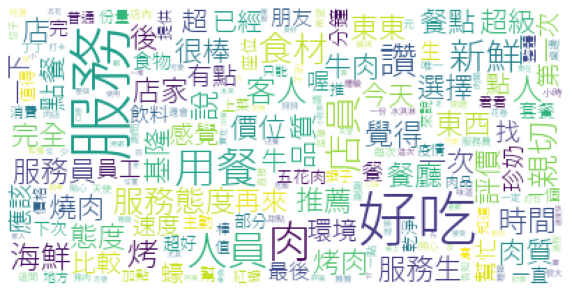

新北市
[('好吃', 290), ('服務', 277), ('店員', 83), ('烤', 82), ('親切', 80), ('肉', 76), ('人員', 71), ('新鮮', 69), ('用餐', 64), ('食材', 62)]


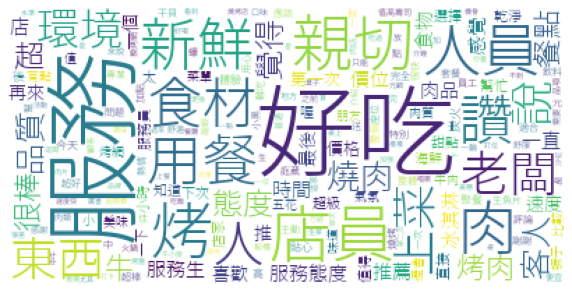

新竹市
[('好吃', 263), ('服務', 175), ('烤', 67), ('肉', 65), ('店員', 65), ('新鮮', 65), ('食材', 55), ('牛', 53), ('用餐', 50), ('讚', 47)]


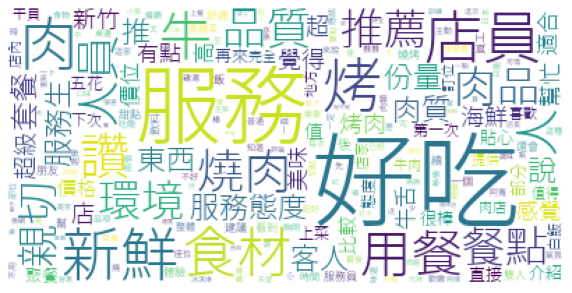

桃園市
[('好吃', 404), ('服務', 347), ('食材', 94), ('新鮮', 94), ('肉', 91), ('人員', 89), ('烤', 89), ('店員', 81), ('讚', 77), ('用餐', 74)]


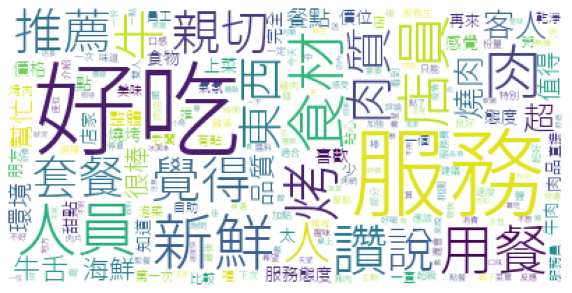

高雄市
[('服務', 398), ('好吃', 329), ('人員', 137), ('用餐', 111), ('烤', 111), ('食材', 98), ('新鮮', 93), ('肉', 92), ('親切', 88), ('店員', 80)]


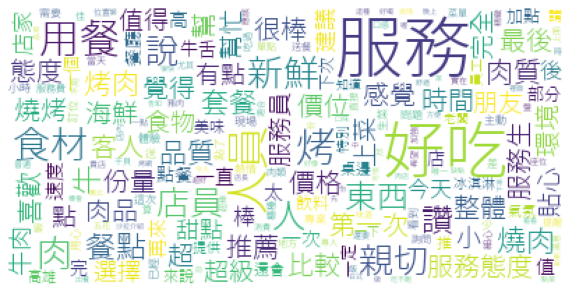

In [ ]:
for city in list(df_review.index):
  review_analytics = df_review.loc[city, '評論']
  terms = []
  for text in review_analytics:
    for t in jieba.cut(text, cut_all=False):
        if t not in stops and emojis.get(t) == set() and is_contains_chinese(t):
            terms.append(t)
  diction = Counter(terms)
  print(city)
  print(diction.most_common(10))
  #wordcloud = WordCloud(font_path='taipei_sans_tc_beta.ttf') 
  #mask = np.array(Image.open("heart2.jpeg")) 
  wordcloud = WordCloud(background_color="white", font_path='taipei_sans_tc_beta.ttf')#, mask=mask) 
  wordcloud.generate_from_frequencies(frequencies=diction)
  plt.figure(figsize=(10, 10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()